# Phase Construction

In [1]:
import os,sys
import pandas as pd
import numpy as np
import sympy as sym
import time
import re
import types
import ast
import sys
from thermocodegen.coder import coder
sym.init_printing()

sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phase import SLBPhase

#pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

In [2]:
reference= 'View_SLBPhase'

In [3]:
def literal_return(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return None
converter = dict([(h,literal_return) for h in ['endmember_names','conversion_strs','d','W','sites','TC0','VD','SD']])
df = pd.read_csv(os.path.join(os.path.pardir, 'database', 'data', 'slb_phases.csv'),skipinitialspace=True,converters=converter)
df

,name,abbrev,endmember_names,formula_str,conversion_strs,X,d,W,sites,TC0,VD,SD
0,Feldspar,plg,"[Anorthite, Albite]",Na[Na]Ca[Ca]Al[Al]Si[Si]O8,"[[0]=[Ca], [1]=[Na]]","[1.0, 1.0]","[1.0, 1.0]",[26000.0],"[[1.0, [1.0, 0.0]], [1.0, [0.0, 1.0]]]",None,None,None
1,Olivine,ol,"[Forsterite, Fayalite]",Mg[Mg]Fe[Fe]SiO4,"[[0]=[Mg]/2.0, [1]=[Fe]/2.0]","[1.0, 1.0]","[1.0, 1.0]",[7600.0],"[[2.0, [1.0, 0.0]], [2.0, [0.0, 1.0]]]",None,None,None
2,Wadsleyite,wa,"[MgWadsleyite, FeWadsleyite]",Mg[Mg]Fe[Fe]SiO4,"[[0]=[Mg]/2.0, [1]=[Fe]/2.0]","[1.0, 1.0]","[1.0, 1.0]",[16500.0],"[[2.0, [1.0, 0.0]], [2.0, [0.0, 1.0]]]",None,None,None
3,Ringwoodite,ri,"[MgRingwoodite, FeRingwoodite]",Mg[Mg]Fe[Fe]SiO4,"[[0]=[Mg]/2.0, [1]=[Fe]/2.0]","[1.0, 1.0]","[1.0, 1.0]",[9100.0],"[[2.0, [1.0, 0.0]], [2.0, [0.0, 1.0]]]",None,None,None
4,Perovskite,pv,"[MgPerovskite, FePerovskite, AlPerovskite]",Mg[Mg]Fe[Fe]Al[Al]Si[Si]O3,"[[0]=[Mg], [1]=[Fe], [2]=[Al]/2.0]","[1.0, 1.0, 1.0]","[1.0, 1.0, 0.39]","[0.0, 116000.0, 0.0]","[[1.0, [1.0, 0.0, 0.0]], [1.0, [0.0, 1.0, 0.0]...",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
56,MgCaFerrite,mgcf,[MgCaFerrite],Mg[Mg]Al2O4,[[0]=[Mg]],[1.0],[1.0],[],[],None,None,None
57,FeCaFerrite,fecf,[FeCaFerrite],Fe[Fe]Al2O4,[[0]=[Fe]],[1.0],[1.0],[],[],None,None,None
58,NaCaFerrite,nacf,[NaCaFerrite],Na[Na]AlSiO4,[[0]=[Na]],[1.0],[1.0],[],[],None,None,None
59,Kyanite,ky,[Kyanite],Al[Al]SiO5,[[0]=[Al]/2.0],[1.0],[1.0],[],[],None,None,None


## Solution Phase Example: Perovskite

In [4]:
values_dict = df.loc[df['name']=='Perovskite'].reset_index(drop=True).iloc[0].to_dict()
pv = SLBPhase(reference=reference,**values_dict)

### Standard state contribution to solution properties

In [5]:
pv.G_ss_default()

### Configurational Gibbs free energy

Mixing on sites.  The SLB model for the configurational Gibbs Free Energy can be written

$$
    G_{conf} = RT \mathbf{m}^T\text{diag}(\mathbf{x}^*)\log(\mathbf{x}^*)
$$

where $\mathbf{m}$ is a vector containing the site multiplicity of length `ns`

For the [MgFeAl][AlSi]O$_3$ system there are 5 sites each with multiplicity 1 so

$$
    \mathbf{m}^T=\begin{bmatrix} 1 & 1 & 1 & 1 & 1\end{bmatrix}
$$

$$
\mathbf{x}^* = C\mathbf{x}
$$ 

is the vector of mole fractions on each site and $C$ is a matrix of site Coefficients.

For this system $C=\begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 0 & 0 & 1 \\ 1 & 1 & 0\end{bmatrix}$

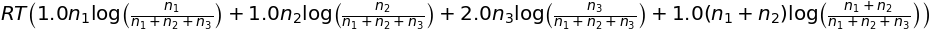

In [6]:
pv.G_config_default()

### Excess Gibbs free energy of mixing

SLB uses a van Laar model for describing the excess Gibbs free energy

$$
    G_{ex} = \mathbf{x}^T\mathbf{d}
    \left[ \mathbf{\Phi}^T W^*\mathbf{\Phi}\right]
$$

where $\mathbf{d}$ is a vector containing species weights (length $c$, number of components)

$$
    \mathbf{\Phi} = \frac{\text{diag}(\mathbf{d})\mathbf{x}}{\mathbf{d}^T\mathbf{x}}
$$

is a vector of $d$ weighted mol fractions and

$$
    W^*_{i,j} = \frac{W_{i,j}}{d_i + d_j}
$$

is a $\mathbf{d}$ weighted Margules matrix $W$ of species interaction terms.

For the [MgFeAl][AlSi]O$_3$ system $W$ is a $3\times3$ symmetric matrix with one off-diagonal terms $W_{1,3}=W_{3,1}$ and $\mathbf{d}^T = \begin{bmatrix} 1 & 1 & 0.39 \end{bmatrix}$

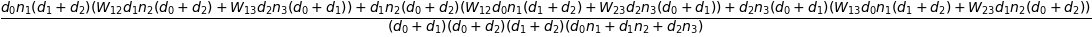

In [7]:
pv.G_excess_default()

### Landau contribution to Gibbs energy

In [8]:
pv.G_landau_default()

### Total Gibbs energy

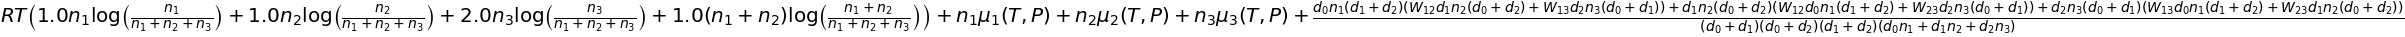

In [9]:
pv.G_default()

In [10]:
pv.params()

[('R', 'J/K/mol', R),
 ('T_r', 'K', T_r),
 ('d_0', '', d_0),
 ('d_1', '', d_1),
 ('d_2', '', d_2),
 ('W_12', 'J/mol', W_12),
 ('W_13', 'J/mol', W_13),
 ('W_23', 'J/mol', W_23)]

In [11]:
pv.values_dict()

{'formula_string': 'Mg[Mg]Fe[Fe]Al[Al]Si[Si]O3',
 'conversion_string': ['[0]=[Mg]', '[1]=[Fe]', '[2]=[Al]/2.0'],
 'test_string': ['[0] > 0.0', '[1] > 0.0', '[2] > 0.0'],
 'name': 'Perovskite',
 'abbrev': 'pv',
 'reference': 'View_SLBPhase',
 'endmembers': ['MgPerovskite', 'FePerovskite', 'AlPerovskite'],
 'R': 8.31446261815324,
 'T_r': 300.0,
 'd_0': 1.0,
 'd_1': 1.0,
 'd_2': 0.39,
 'W_12': 0.0,
 'W_13': 116000.0,
 'W_23': 0.0}

## Pure Phase Example: Quartz

In [12]:
values_dict = df.loc[df['name']=='Quartz'].reset_index(drop=True).iloc[0].to_dict()
qz = SLBPhase(reference=reference,**values_dict)

In [13]:
qz.G_ss_default()

In [14]:
qz.G_config_default()

In [15]:
qz.G_excess_default()

In [16]:
qz.G_landau_default()

⎧                                                                             
⎪                                                               0             
⎪                                                                             
⎪                                                                             
⎪       __________________________________                                    
⎨      ╱ P⋅V_D_0 - S_D_0⋅T + S_D_0⋅T_C0_0  ⎛             S_D_0⋅T_C0_0⋅(P⋅V_D_0
⎪n₁⋅  ╱  ──────────────────────────────── ⋅⎜-3⋅P⋅V_D_0 + ─────────────────────
⎪   ╲╱        P⋅V_D_0 + S_D_0⋅T_C0_0       ⎝                          P⋅V_D_0 
⎪─────────────────────────────────────────────────────────────────────────────
⎪                                                               3             
⎩                                                                             

                                                             P⋅V_D_0         
                                                    

In [17]:
qz.G_default()

              ⎛⎧                                                              
              ⎜⎪                                                              
              ⎜⎪                                                              
              ⎜⎪                                                              
              ⎜⎪       __________________________________                     
n₁⋅μ₁(T, P) + ⎜⎨      ╱ P⋅V_D_0 - S_D_0⋅T + S_D_0⋅T_C0_0  ⎛             S_D_0⋅
              ⎜⎪n₁⋅  ╱  ──────────────────────────────── ⋅⎜-3⋅P⋅V_D_0 + ──────
              ⎜⎪   ╲╱        P⋅V_D_0 + S_D_0⋅T_C0_0       ⎝                   
              ⎜⎪──────────────────────────────────────────────────────────────
              ⎜⎪                                                              
              ⎝⎩                                                              

                                                                            P⋅
 0                                                 

In [18]:
qz.params()

[('R', 'J/K/mol', R),
 ('T_r', 'K', T_r),
 ('d_0', '', d_0),
 ('T_C0_0', 'K', T_C0_0),
 ('V_D_0', 'cm^3/mol/10', V_D_0),
 ('S_D_0', 'J/mol/K', S_D_0)]

In [19]:
qz.values_dict()

{'formula_string': 'Si[Si]O2',
 'conversion_string': ['[0]=[Si]'],
 'test_string': ['[0] > 0.0'],
 'name': 'Quartz',
 'abbrev': 'qtz',
 'reference': 'View_SLBPhase',
 'endmembers': ['Quartz'],
 'R': 8.31446261815324,
 'T_r': 300.0,
 'd_0': 1.0,
 'T_C0_0': 847.0,
 'V_D_0': 0.1222,
 'S_D_0': 5.164}